# Reward-based POIS analysis
In this notebook we are going to show the results of the reward-based importance weighting for the POIS algorithm. As in PDIS notebook, we start by loading all our runs and by defining a base run filter.

In [3]:
import sys
sys.path = ['..'] + sys.path
import pandas as pd
import numpy as np
import glob, sys, json, re
import matplotlib.pyplot as plt
import scipy.stats as sts
from sacred_notebook_utils import plot_mean_ci, plot_all
from baselines.common.sacred_utils import load_runs, filter_runs

In [4]:
runs = load_runs('../../../sacred_data/sacred_runs_master/')
print("Loaded runs:", len(runs.keys()))
final_runs = load_runs('../../../sacred_data/sacred_runs_final/')
print("Loaded final runs:", len(final_runs.keys()))

Loaded runs: 572
Loaded final runs: 704


In [5]:
base_query = {
    'run.status': 'COMPLETED',
    'config.center': False,
    'config.gamma': 0.99,
    'config.clipping': False,
    'config.njobs': 1,
    'config.natural': False,
    'config.policy': 'linear',
    'config.iw_norm': 'none'
}

## CartPole as a test
Now we are going to see if the reward-based POIS has a comparative performance w.r.t. vanilla POIS, given also that in the CartPole environment the rewards are very broadly distributed, since the reward is simply the length of the episode times 10. It ranges from 0 to 5000. This means that, without any reward clustering, the reward-based estimator should work the same as the vanilla estimator.

----------------------------------------
Method: is  - Delta: 0.4
Experiments: 10
Seeds: 904, 570, 109, 160, 904, 109, 10, 570, 10, 160
----------------------------------------
Method: rbis  - Delta: 0.2
Experiments: 5
Seeds: 109, 570, 904, 160, 10
----------------------------------------
Method: rbis  - Delta: 0.4
Experiments: 5
Seeds: 904, 10, 109, 160, 570
----------------------------------------
Method: rbis  - Delta: 0.6
Experiments: 5
Seeds: 10, 160, 570, 904, 109
----------------------------------------
Method: rbis  - Delta: 0.9
Experiments: 5
Seeds: 160, 570, 109, 10, 904


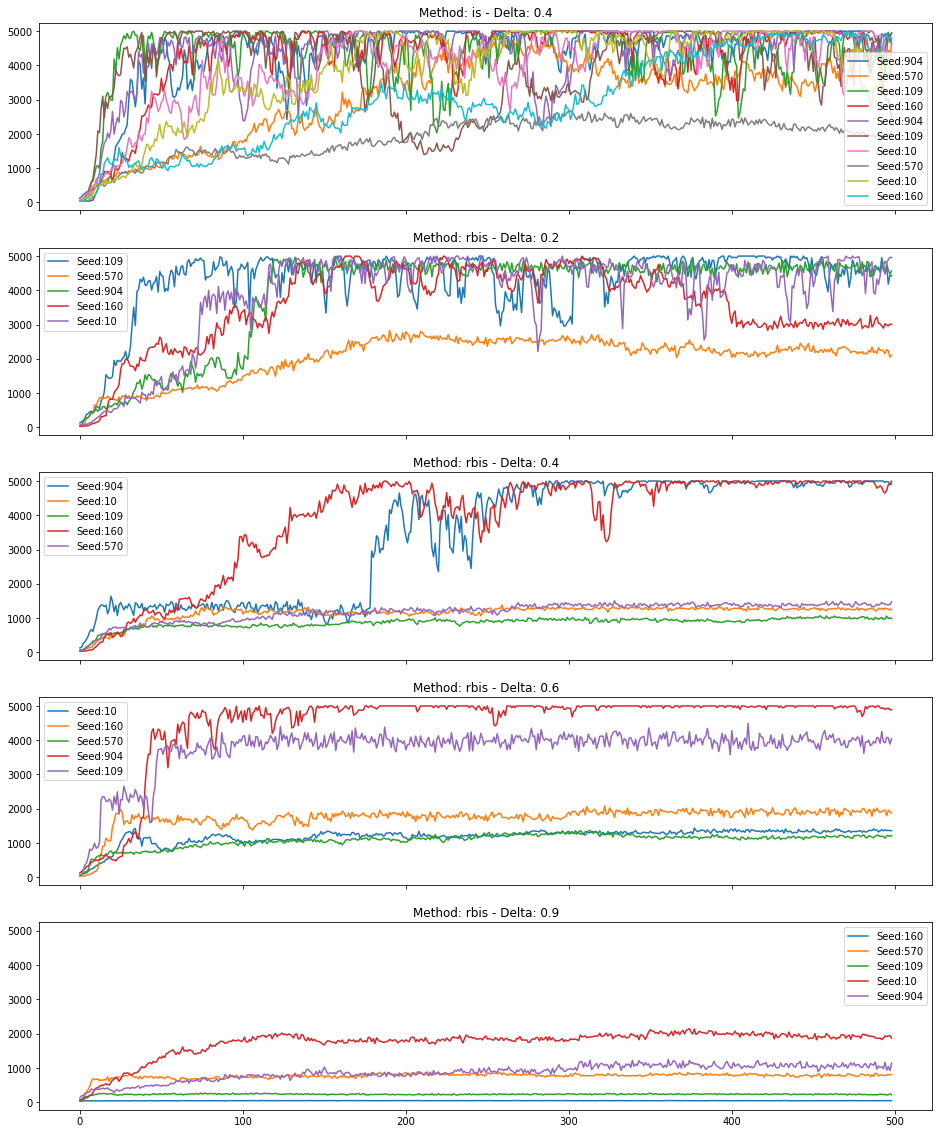

In [6]:
fig, axis = plt.subplots(nrows=5, ncols=1, figsize=(16,20), sharex=True, sharey=True)
for i, (method, delta) in enumerate([('is', 0.4),
                                              ('rbis', 0.2),
                                              ('rbis', 0.4),
                                              ('rbis', 0.6),
                                              ('rbis', 0.9)
                                             ]):
    query = {
        'config.entropy': 'none',
        'config.env': 'rllab.cartpole',
        'config.iw_method': method,
        'config.delta': delta,
        'config.bound': 'max-d2',
        'config.num_episodes': 100,
        'config.reward_clustering': 'none'
    }
    filtered_runs = filter_runs({**base_query, **query}, runs, avoid_missing=False)
    print('----------------------------------------')
    print("Method:", method, " - Delta:", delta)
    print("Experiments:", len(filtered_runs.keys()))
    print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))
    plot_all(filtered_runs, 'EpRewMean', axis[i])
    axis[i].set_title("Method: " + method + " - Delta: " + str(delta))
plt.show();

As we can notice, a delta of 0.2 makes the RBIS estimator comparable to the vanilla one, while being quite sensible to the choice of delta. This is probably because the bound we are using is not specific for the reward-base strategy, since the max-d2 (vanilla) has been used.

## Reward clustering
Now we want to understand the influence of the reward clustering w.r.t. the performances of the algorithm. We start with a "manual" reward clustering (again on rllab.cartpole) from 0 to 5000 with 1000 intervals of 5

----------------------------------------
Method: rbis  - Delta: 0.1
Experiments: 5
Seeds: 10, 109, 570, 160, 904
----------------------------------------
Method: rbis  - Delta: 0.2
Experiments: 5
Seeds: 904, 10, 570, 109, 160
----------------------------------------
Method: rbis  - Delta: 0.4
Experiments: 5
Seeds: 570, 160, 904, 10, 109


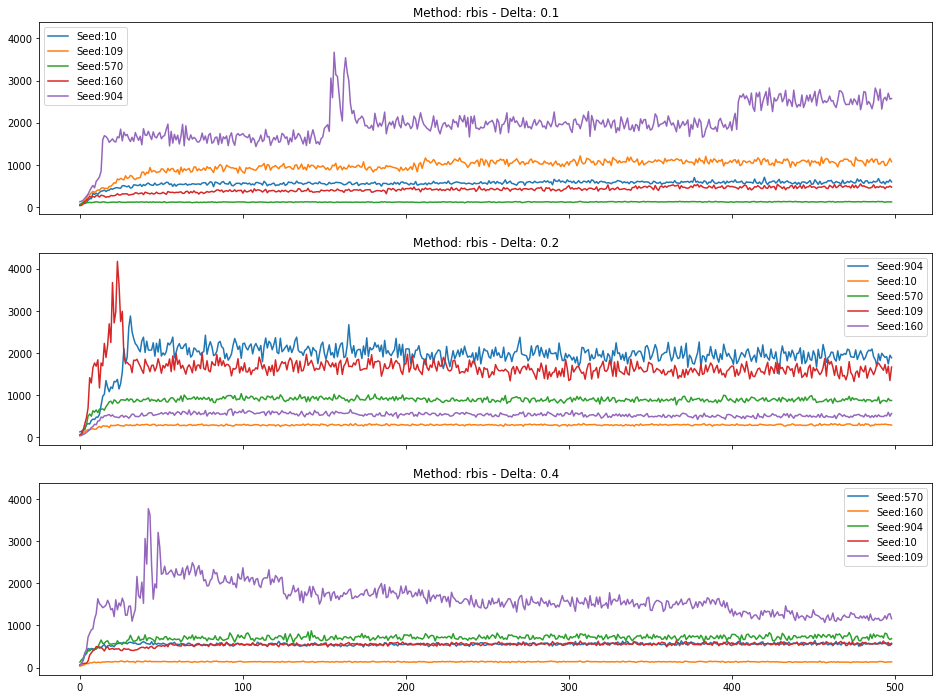

In [7]:
fig, axis = plt.subplots(nrows=3, ncols=1, figsize=(16,12), sharex=True, sharey=True)
for i, (method, delta) in enumerate([('rbis', 0.1),
                                    ('rbis', 0.2),
                                    ('rbis', 0.4)
                                             ]):
    query = {
        'config.entropy': 'none',
        'config.env': 'rllab.cartpole',
        'config.iw_method': method,
        'config.delta': delta,
        'config.bound': 'max-d2',
        'config.num_episodes': 100,
        'config.reward_clustering': 'manual:1000:0:5000'
    }
    filtered_runs = filter_runs({**base_query, **query}, runs)
    print('----------------------------------------')
    print("Method:", method, " - Delta:", delta)
    print("Experiments:", len(filtered_runs.keys()))
    print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))
    plot_all(filtered_runs, 'EpRewMean', axis[i])
    axis[i].set_title("Method: " + method + " - Delta: " + str(delta))
plt.show();

We can notice how the performances of the algorithm are much worse even when the approximation performed during clustering is not so strict. We must inspect these effects more. 

We can try to make the discretization even softer and see what happens.

----------------------------------------
Method: rbis  - Delta: 0.01
Experiments: 5
Seeds: 570, 904, 10, 160, 109
----------------------------------------
Method: rbis  - Delta: 0.1
Experiments: 5
Seeds: 904, 570, 109, 160, 10
----------------------------------------
Method: rbis  - Delta: 0.2
Experiments: 5
Seeds: 160, 10, 109, 570, 904


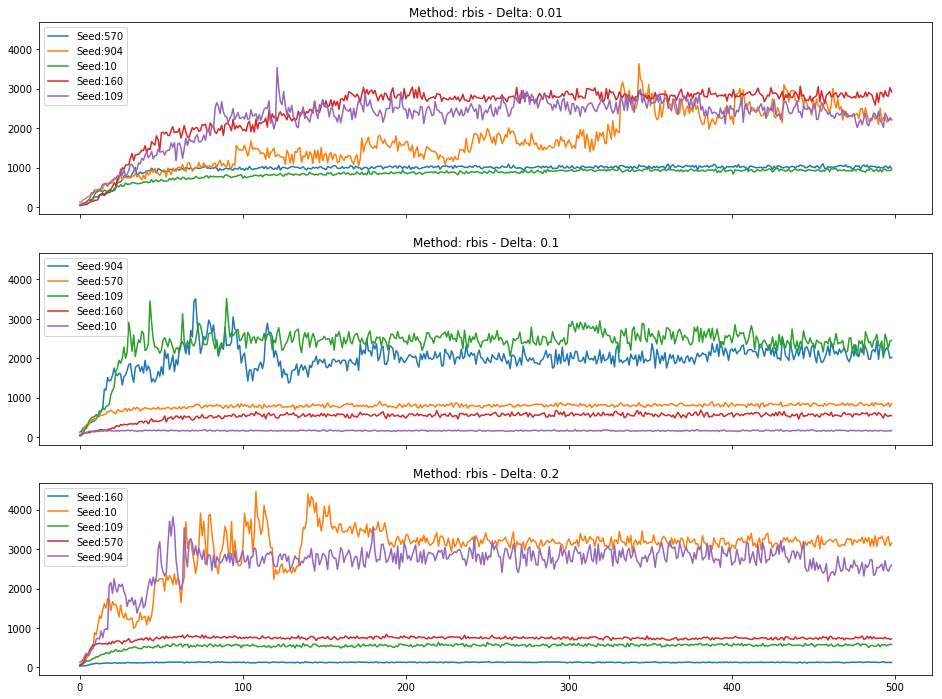

In [8]:
fig, axis = plt.subplots(nrows=3, ncols=1, figsize=(16,12), sharex=True, sharey=True)
for i, (method, delta) in enumerate([('rbis', 0.01),
                                    ('rbis', 0.1),
                                    ('rbis', 0.2)
                                             ]):
    query = {
        'config.entropy': 'none',
        'config.env': 'rllab.cartpole',
        'config.iw_method': method,
        'config.delta': delta,
        'config.bound': 'max-d2',
        'config.num_episodes': 100,
        'config.reward_clustering': 'manual:50000:0:5000'
    }
    filtered_runs = filter_runs({**base_query, **query}, runs)
    print('----------------------------------------')
    print("Method:", method, " - Delta:", delta)
    print("Experiments:", len(filtered_runs.keys()))
    print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))
    plot_all(filtered_runs, 'EpRewMean', axis[i])
    axis[i].set_title("Method: " + method + " - Delta: " + str(delta))
plt.show();

The results are better but we are still far from optimal, since there are 2/3 runs over 5 which remain almost stuck.

## Second version of the estimator
Since the first version of the estimator
$$\hat{J}= \frac{1}{|R|}\sum_{c \in R}{\omega(c) r(c)}$$ 
where R is the set of reward clusters, omega is the importance weight and r(c) is the reward of the cluster
has clearly some problems, we modified it to:
$$\hat{J}= \frac{1}{|N|}\sum_{c \in R}{\omega(c) r(c) n(c)}$$ 
where N is the number of trajectories and n(c) is the number of trajectories in the cluster.
So, we now plot some results to understand if the previous estimator was not correct.

Again, we first test the method without reward clustering to understand if the algorithm is working in a basic case.

----------------------------------------
Method: is  - Delta: 0.4
Experiments: 10
Seeds: 904, 570, 109, 160, 904, 109, 10, 570, 10, 160
----------------------------------------
Method: rbis  - Delta: 0.2
Experiments: 5
Seeds: 160, 109, 570, 904, 10
----------------------------------------
Method: rbis  - Delta: 0.4
Experiments: 5
Seeds: 160, 904, 10, 109, 570
----------------------------------------
Method: rbis  - Delta: 0.6
Experiments: 5
Seeds: 160, 904, 570, 109, 10
----------------------------------------
Method: rbis  - Delta: 0.8
Experiments: 5
Seeds: 904, 10, 160, 109, 570


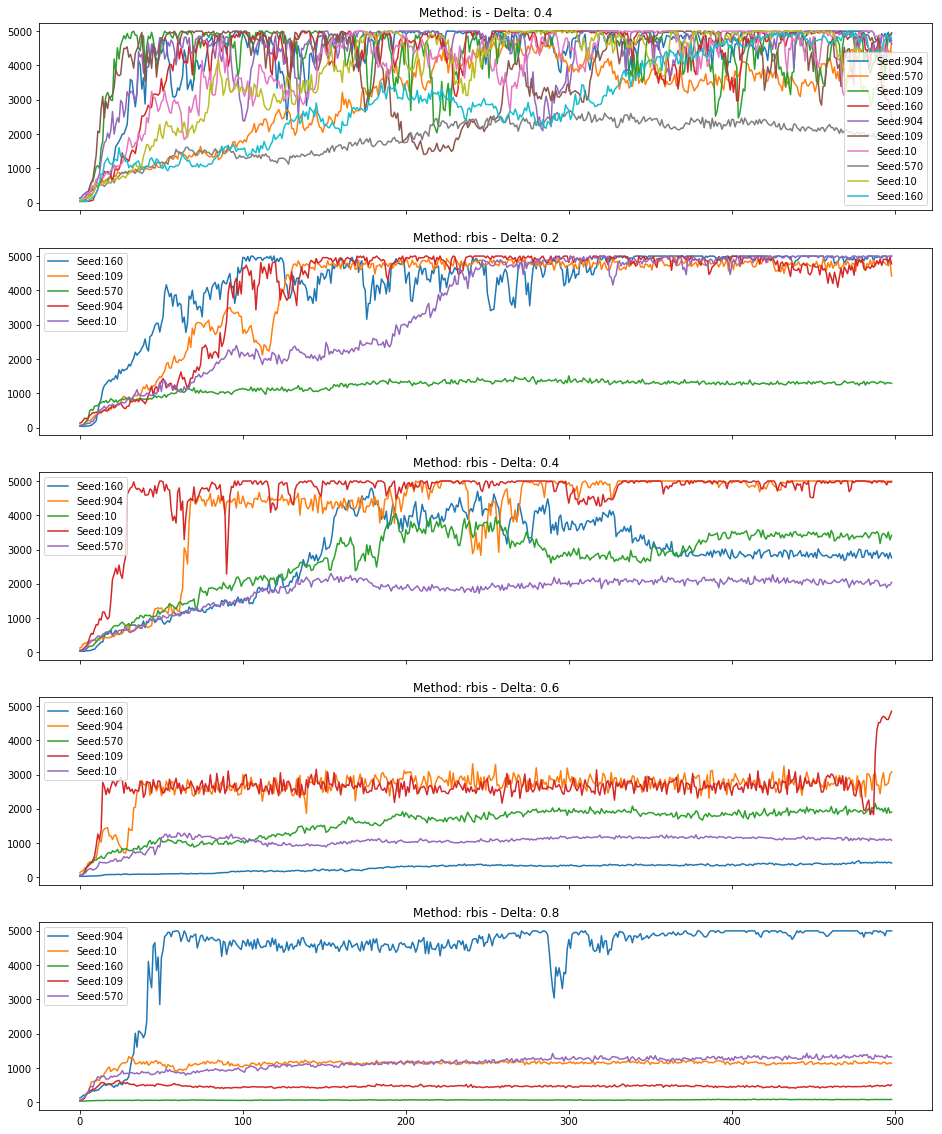

In [9]:
# We used iw_norm to set version of the estimator. So we first remove it from the base query
base_query.pop('iw_norm', None)

fig, axis = plt.subplots(nrows=5, ncols=1, figsize=(16,20), sharex=True, sharey=True)
for i, (method, delta, iw_norm) in enumerate([('is', 0.4, 'none'),
                                              ('rbis', 0.2, 'clustrew'),
                                              ('rbis', 0.4, 'clustrew'),
                                              ('rbis', 0.6, 'clustrew'),
                                              ('rbis', 0.8, 'clustrew')
                                             ]):
    query = {
        'config.entropy': 'none',
        'config.env': 'rllab.cartpole',
        'config.iw_method': method,
        'config.delta': delta,
        'config.bound': 'max-d2',
        'config.num_episodes': 100,
        'config.reward_clustering': 'none',
        'config.iw_norm': iw_norm
    }
    filtered_runs = filter_runs({**base_query, **query}, runs, avoid_missing=False)
    print('----------------------------------------')
    print("Method:", method, " - Delta:", delta)
    print("Experiments:", len(filtered_runs.keys()))
    print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))
    plot_all(filtered_runs, 'EpRewMean', axis[i])
    axis[i].set_title("Method: " + method + " - Delta: " + str(delta))
plt.show();

This strategy seem promising but again, we need to carefully choose the delta parameter. We can now try the algorithm using the reward discretization again.

----------------------------------------
Method: rbis  - Delta: 0.2
Experiments: 5
Seeds: 10, 109, 160, 904, 570
----------------------------------------
Method: rbis  - Delta: 0.4
Experiments: 5
Seeds: 10, 570, 160, 109, 904
----------------------------------------
Method: rbis  - Delta: 0.6
Experiments: 5
Seeds: 10, 570, 109, 160, 904
----------------------------------------
Method: rbis  - Delta: 0.8
Experiments: 5
Seeds: 570, 10, 109, 904, 160


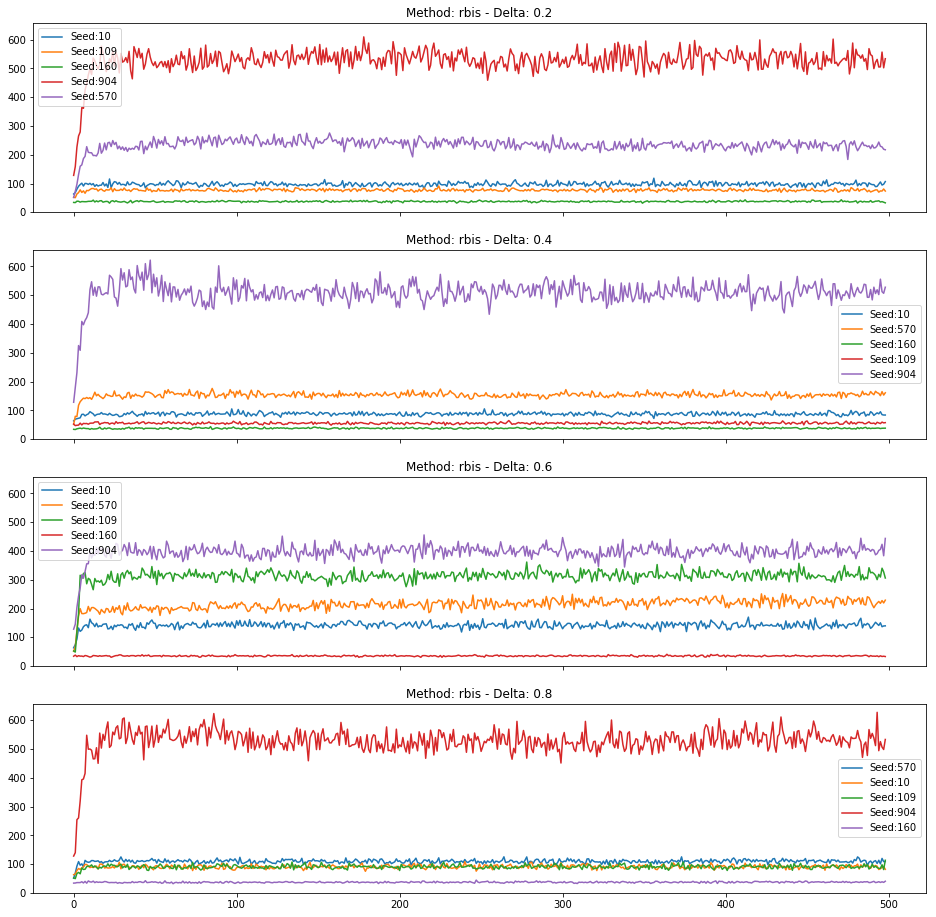

In [10]:
fig, axis = plt.subplots(nrows=4, ncols=1, figsize=(16,16), sharex=True, sharey=True)
for i, (method, delta, iw_norm) in enumerate([('rbis', 0.2, 'clustrew'),
                                              ('rbis', 0.4, 'clustrew'),
                                              ('rbis', 0.6, 'clustrew'),
                                              ('rbis', 0.8, 'clustrew')
                                             ]):
    query = {
        'config.entropy': 'none',
        'config.env': 'rllab.cartpole',
        'config.iw_method': method,
        'config.delta': delta,
        'config.bound': 'max-d2',
        'config.num_episodes': 100,
        'config.reward_clustering': 'manual:5000:0:5000',
        'config.iw_norm': iw_norm
    }
    filtered_runs = filter_runs({**base_query, **query}, runs, avoid_missing=False)
    print('----------------------------------------')
    print("Method:", method, " - Delta:", delta)
    print("Experiments:", len(filtered_runs.keys()))
    print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))
    plot_all(filtered_runs, 'EpRewMean', axis[i])
    axis[i].set_title("Method: " + method + " - Delta: " + str(delta))
plt.show();

These results are quite strange, since using reward-clustering (and a very soft one), it seems that the algorithm is not capable of learning any particularly good behavior (notice the scale of the plots, still far from the 5000 optimal reward).

## Checking reward clustering with vanilla-IS
To understand if there is a problem with the reward clustering itself or if is the estimator which is not behaving properly, we want to apply reward clustering to the vanilla-IS case, which is known to work, so it will act as our baseline.

----------------------------------------
Method: is  - Delta: 0.4
Experiments: 5
Seeds: 109, 904, 570, 10, 160
----------------------------------------
Method: is  - Delta: 0.4
Experiments: 5
Seeds: 904, 109, 10, 570, 160
----------------------------------------
Method: is  - Delta: 0.4
Experiments: 5
Seeds: 570, 109, 10, 160, 904


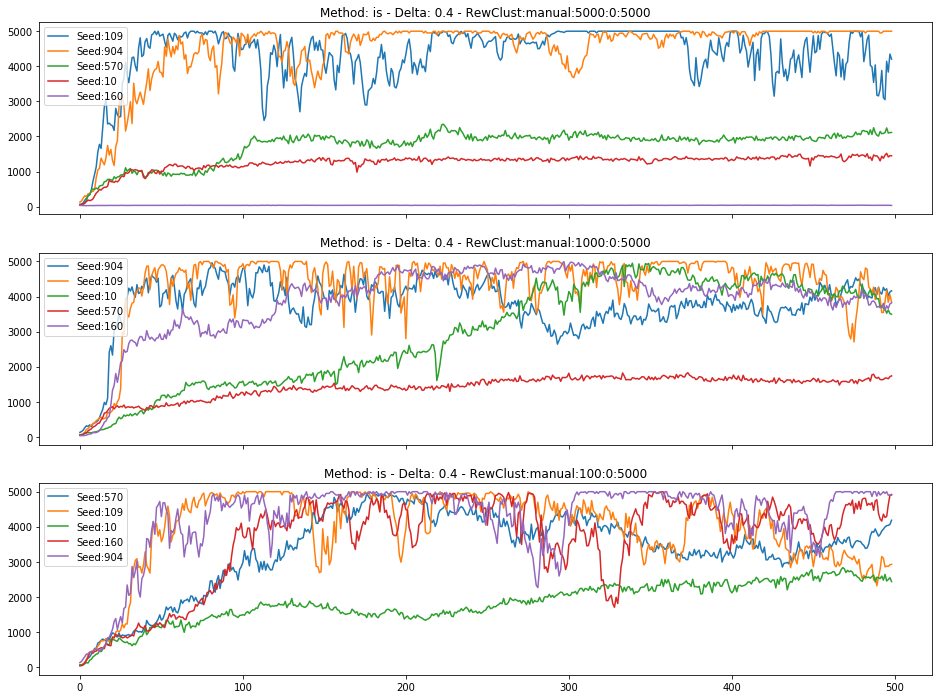

In [11]:
fig, axis = plt.subplots(nrows=3, ncols=1, figsize=(16,12), sharex=True, sharey=True)
for i, (method, delta, rewclust) in enumerate([('is', 0.4, 'manual:5000:0:5000'),
                                              ('is', 0.4, 'manual:1000:0:5000'),
                                              ('is', 0.4, 'manual:100:0:5000'),
                                             ]):
    query = {
        'config.entropy': 'none',
        'config.env': 'rllab.cartpole',
        'config.iw_method': method,
        'config.delta': delta,
        'config.bound': 'max-d2',
        'config.num_episodes': 100,
        'config.reward_clustering': rewclust,
        'run.experiment.repositories.commit': '06b84287e76bb65cf1d4ff4470ef4923b72e0794'
    }
    filtered_runs = filter_runs({**base_query, **query}, runs, avoid_missing=False)
    print('----------------------------------------')
    print("Method:", method, " - Delta:", delta)
    print("Experiments:", len(filtered_runs.keys()))
    print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))
    plot_all(filtered_runs, 'EpRewMean', axis[i])
    axis[i].set_title("Method: " + method + " - Delta: " + str(delta) + " - RewClust:" + str(rewclust))
plt.show();

As we can notice, there is a strange behavior: when the clustering is very fine-grained the performances seems to be worse than the coarse-grained clustering. This is strange because a fine-grained discretization should have very similar performance w.r.t. the vanilla-IS. We want now to check 2 things:
- Clustering is done after the max_reduce which is used for the bound, can this affect the performances?
- Clustering is done by flooring the rewards to the nearest "clusteroid", what happens if we ceil instead?

## Max reward after clustering

----------------------------------------
Method: is  - Delta: 0.4
Experiments: 5
Seeds: 109, 160, 570, 10, 904
----------------------------------------
Method: is  - Delta: 0.4
Experiments: 4
Seeds: 10, 904, 109, 570
----------------------------------------
Method: is  - Delta: 0.4
Experiments: 5
Seeds: 109, 160, 10, 904, 570


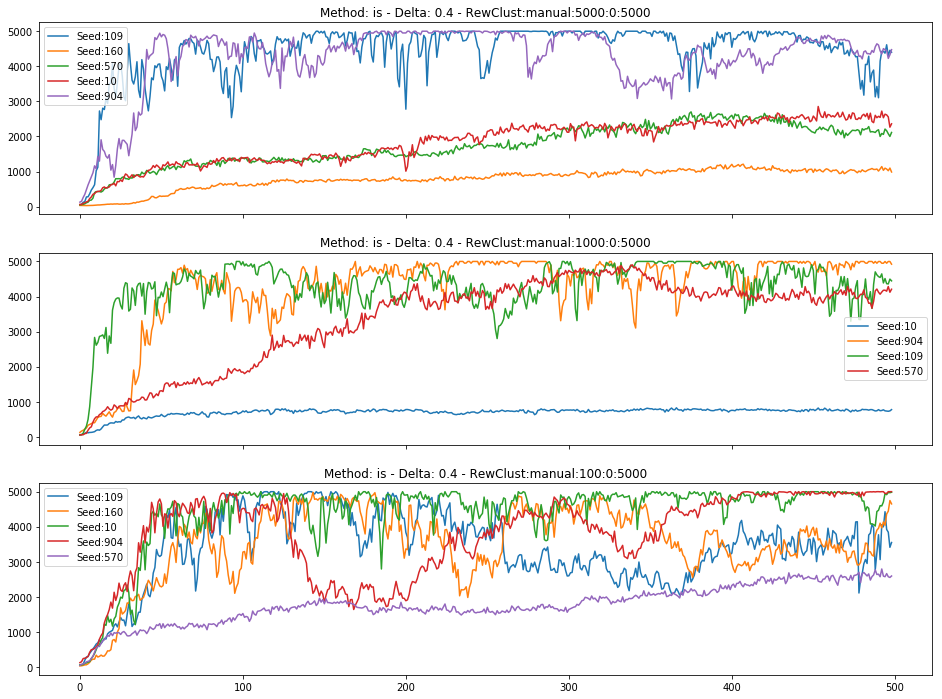

In [12]:
fig, axis = plt.subplots(nrows=3, ncols=1, figsize=(16,12), sharex=True, sharey=True)
for i, (method, delta, rewclust) in enumerate([('is', 0.4, 'manual:5000:0:5000'),
                                              ('is', 0.4, 'manual:1000:0:5000'),
                                              ('is', 0.4, 'manual:100:0:5000'),
                                             ]):
    query = {
        'config.entropy': 'none',
        'config.env': 'rllab.cartpole',
        'config.iw_method': method,
        'config.delta': delta,
        'config.bound': 'max-d2',
        'config.num_episodes': 100,
        'config.reward_clustering': rewclust,
        'run.experiment.repositories.commit': 'da7828a4046dc3a34dfce37c281f0a42a69b6248'
    }
    filtered_runs = filter_runs({**base_query, **query}, runs, avoid_missing=False)
    print('----------------------------------------')
    print("Method:", method, " - Delta:", delta)
    print("Experiments:", len(filtered_runs.keys()))
    print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))
    plot_all(filtered_runs, 'EpRewMean', axis[i])
    axis[i].set_title("Method: " + method + " - Delta: " + str(delta) + " - RewClust:" + str(rewclust))
plt.show();

There seems to be a slight improvement, probably caused by a more exact bound computation, so probably less restrictive. But still, the inverse behavior is present, which is difficult to explain.

## Clustering outside TF graph
We also try to avoid the usage of tensorflow in performing the clustering, in order to exclude any cause related to the framework.

----------------------------------------
Method: is  - Delta: 0.4
Experiments: 5
Seeds: 904, 570, 109, 10, 160
----------------------------------------
Method: is  - Delta: 0.4
Experiments: 5
Seeds: 570, 10, 109, 160, 904
----------------------------------------
Method: is  - Delta: 0.4
Experiments: 5
Seeds: 109, 904, 570, 10, 160
----------------------------------------
Method: is  - Delta: 0.4
Experiments: 5
Seeds: 160, 570, 904, 10, 109
----------------------------------------
Method: is  - Delta: 0.4
Experiments: 5
Seeds: 109, 570, 904, 160, 10
----------------------------------------
Method: is  - Delta: 0.4
Experiments: 5
Seeds: 904, 160, 10, 109, 570
----------------------------------------
Method: is  - Delta: 0.4
Experiments: 5
Seeds: 109, 10, 160, 904, 570


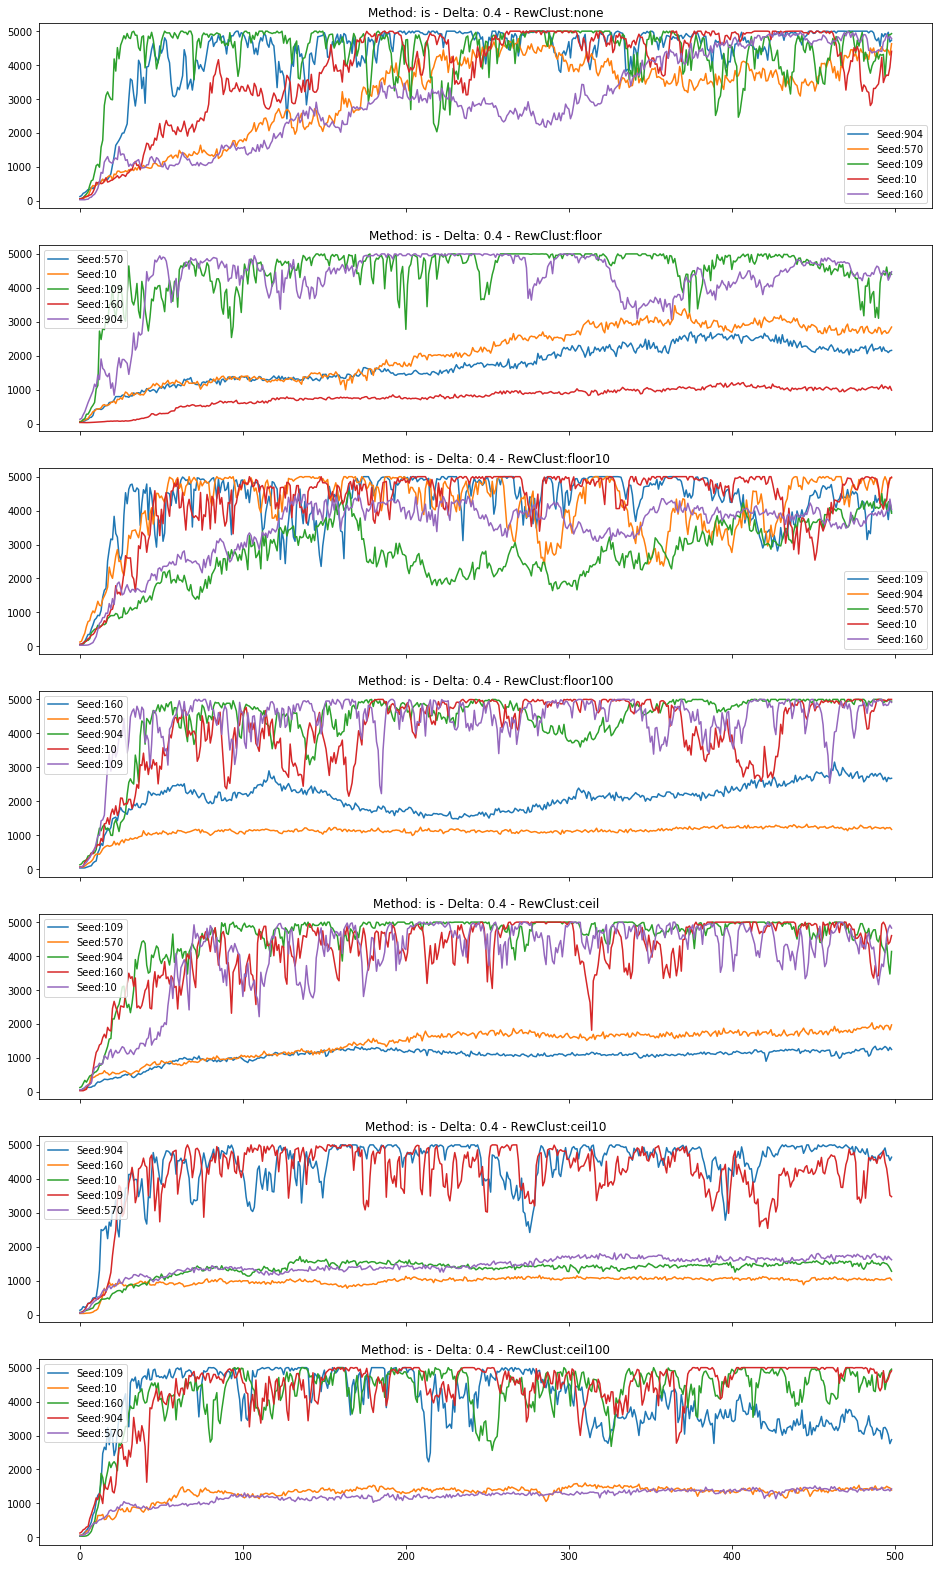

In [13]:
fig, axis = plt.subplots(nrows=7, ncols=1, figsize=(16,28), sharex=True, sharey=True)
for i, (method, delta, rewclust, commit) in enumerate([('is', 0.4, 'none', 'cb1fbb01f6d2dab11ef8bcf6352f63abcc57648b'),
                                               ('is', 0.4, 'floor', 'cb1fbb01f6d2dab11ef8bcf6352f63abcc57648b'),
                                               ('is', 0.4, 'floor10', '8d56b1979a0e50b09202d27dc216a8628575c16c'),
                                               ('is', 0.4, 'floor100', '8d56b1979a0e50b09202d27dc216a8628575c16c'),
                                               ('is', 0.4, 'ceil', '92214acff494494533253e6ec1adcf3e232a1fff'),
                                               ('is', 0.4, 'ceil10', '8d56b1979a0e50b09202d27dc216a8628575c16c'),
                                               ('is', 0.4, 'ceil100', '8d56b1979a0e50b09202d27dc216a8628575c16c'),
                                             ]):
    query = {
        'config.entropy': 'none',
        'config.env': 'rllab.cartpole',
        'config.iw_method': method,
        'config.delta': delta,
        'config.bound': 'max-d2',
        'config.num_episodes': 100,
        'config.reward_clustering': rewclust,
        'run.experiment.repositories.commit': commit
    }
    filtered_runs = filter_runs({**base_query, **query}, runs, avoid_missing=False)
    print('----------------------------------------')
    print("Method:", method, " - Delta:", delta)
    print("Experiments:", len(filtered_runs.keys()))
    print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))
    plot_all(filtered_runs, 'EpRewMean', axis[i])
    axis[i].set_title("Method: " + method + " - Delta: " + str(delta) + " - RewClust:" + str(rewclust))
plt.show();

The first plot is without reward-clustering (our baselines), to check if the return system is correctly implemented outside TF (and it is). The second plot is the reward-clustering performed by flooring the episode rewards, i.e. the same as 'manual:5000:0:5000'. 

The last thing to try out is the ceiling instead of flooring of the episode returns.

# Comments
- The RBIS estimator is working without reward clustering in both the 2 versions we have defined.
- The RBIS estimator seems to have issues with the bound, which could be "misaligned"
- The fact that some runs are stuck in a certain area could be explained by this misalignment
- Reward clustering seems to worsen this effect
- Reward clustering seems not to be working, since with a more coarse-grained discretization the performances are better than the fine-grained discretization in the vanilla-IS case.

# TODO
- Different deltas to make cartpole work
- Cartpole with increasing reward_clustering N